# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044690379054401
RMSE when predicting testing data:
1.0666204347667476
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [5]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [6]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851467026495314


In [7]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289873, -1.09373797, -1.0851467 ])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [8]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [9]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

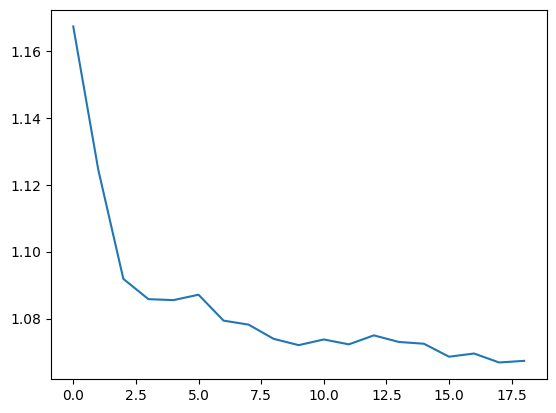

In [10]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

The graph demonstrates the relationship between training set size and the model's predictive performance, as measured by root mean squared error (RMSE). Initially, the RMSE is relatively high when using a small amount of training data. As the training set size increases, the RMSE decreases sharply, indicating an improvement in the model's ability to generalize. However, after a certain point, the RMSE stabilizes, thus showing diminishing returns in performance improvement with further increases in the training set size. The graph highlights the importance of sufficient data for training machine learning models like random forests, while also emphasizing that adding more data beyond a certain threshold may yield limited benefits.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [11]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

Question: I predict that alpha = 0 will result in a worse prediction than alpha = 10. When alpha is set to 0, each stock behaves as an independent, randomly generated series with no underlying structure connecting them. As a result, the target stock has no significant relationship to the other ten stocks, making it difficult for a model, such as random forest, to learn any pattern that could help predict its value. On the other hand, when alpha is set to 10, the majority of each stock’s behavior is influenced by shared underlying factors. These common elements introduce strong correlations between related stocks, which the model can learn and leverage during training. Therefore, with a higher alpha, the model has a clearer structure to work with, thus making its predictions more accurate, especially on unseen test data.

Try it out:

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

def make_X_y(alpha=0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size=num_samples_hwk)
    common_even = np.random.normal(size=num_samples_hwk)
    common_three = np.random.normal(size=num_samples_hwk)

    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
        common /= 2
        df_hwk[f"Stock_{n}"] = np.random.normal(size=num_samples_hwk) + alpha * common

    X = df_hwk.iloc[:, :-1].values
    y = df_hwk.iloc[:, -1].values
    return X, y

def evaluate_alpha(alpha_val):
    X, y = make_X_y(alpha=alpha_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    correlation = spearmanr(y_test, y_pred).correlation
    print(f"Alpha = {alpha_val} → Spearman Correlation: {correlation:.4f}")

evaluate_alpha(0)
evaluate_alpha(10)

Alpha = 0 → Spearman Correlation: 0.0169
Alpha = 10 → Spearman Correlation: 0.9685


Comment on what I learned: After running the experiment, I found that the spearman correlation between the model’s predictions and the true values was very low (0.0169) when alpha = 0 and very high (0.9685) when alpha = 10. This confirms the initial prediction that when there's no shared structure in the data, alpha = 0, the random forest model struggles to make accurate predictions since each stock behaves independently like random noise. However, when alpha is high, the stocks are heavily influenced by common underlying patterns and the model is able to recognize and learn these relationships effectively. A spearman correlation of 0.9685 shows that the model is almost perfectly preserving the ranking of predicted values compared to the actual ones. 

What I learned is that the presence of structure in the data is crucial for model performance. Even a powerful model like random forest can't do much when the features are just noise but when features are correlated in meaningful ways, the model can capture those relationships and produce highly reliable predictions. This also depicted the usefulness of correlation as a metric, especially when we care more about ranking or consistency rather than exact values.

Randomized Search:

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import spearmanr, randint

def make_X_y(alpha=10):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size=num_samples_hwk)
    common_even = np.random.normal(size=num_samples_hwk)
    common_three = np.random.normal(size=num_samples_hwk)

    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
        common /= 2
        df_hwk[f"Stock_{n}"] = np.random.normal(size=num_samples_hwk) + alpha * common

    X = df_hwk.iloc[:, :-1].values
    y = df_hwk.iloc[:, -1].values
    return X, y

X, y = make_X_y(alpha=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

scorer = make_scorer(r2_score)

rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)
best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)
spearman_corr = spearmanr(y_test, y_pred).correlation

print("Best Parameters Found:", rs.best_params_)
print("Test Spearman Correlation:", spearman_corr)

Best Parameters Found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149}
Test Spearman Correlation: 0.971658887914722


Scoring:

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, max_error

max_error_value = max_error(y_test, best_model.predict(X_test))
print("Max Error on Test Set:", max_error_value)

Max Error on Test Set: 4.0376195585571715


What I learned about it: I explored the max_error scoring metric which measures the largest absolute error between the predicted and actual values. It's useful for detecting how bad the worst-case prediction was, regardless of how good the average performance might be. When I applied it to my model, the maximum error on the test set was approximately 4.04. This means that in at least one case, the model’s prediction was over 4 units away from the actual value. While the overall performance, as measured by Spearman correlation, was excellent, max_error gives valuable insight into possible edge cases or outliers the model didn't handle well. It’s a reminder that even high-performing models can still make significant mistakes on certain inputs.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

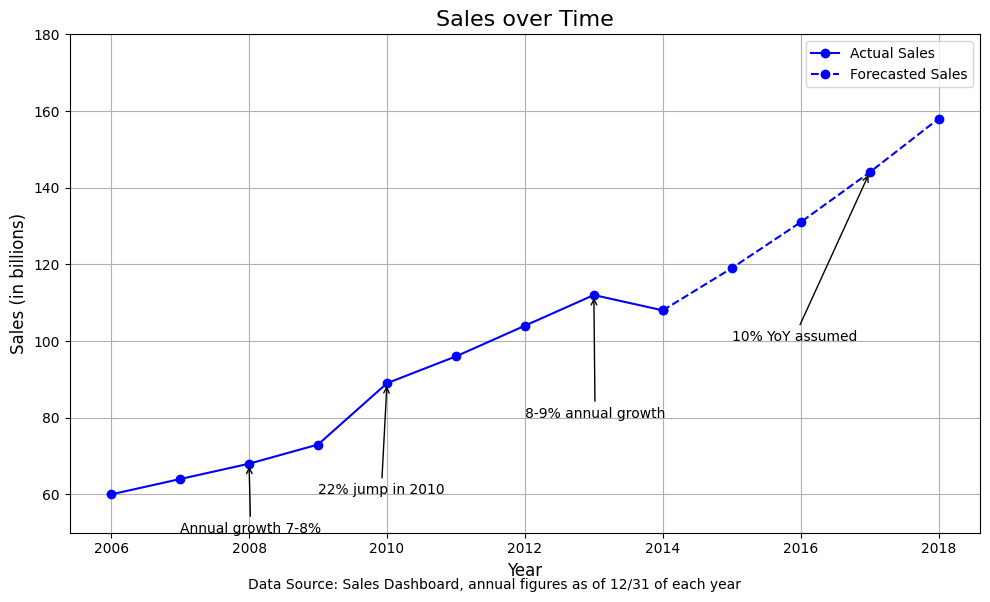

In [23]:
import matplotlib.pyplot as plt

years_actual = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
sales_actual = [60, 64, 68, 73, 89, 96, 104, 112, 108]

years_forecast = [2014, 2015, 2016, 2017, 2018]
sales_forecast = [108, 119, 131, 144, 158]

plt.figure(figsize=(10, 6))

plt.plot(years_actual, sales_actual, marker='o', label='Actual Sales', color='blue')
plt.plot(years_forecast, sales_forecast, marker='o', linestyle='--', label='Forecasted Sales', color='blue')

plt.annotate('Annual growth 7-8%', xy=(2008, 68), xytext=(2007, 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate('22% jump in 2010', xy=(2010, 89), xytext=(2009, 60),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate('8-9% annual growth', xy=(2013, 112), xytext=(2012, 80),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate('10% YoY assumed', xy=(2017, 144), xytext=(2015, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.title('Sales over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales (in billions)', fontsize=12)
plt.ylim(50, 180)
plt.grid(True)

plt.legend()

plt.figtext(0.5, 0.01, 'Data Source: Sales Dashboard, annual figures as of 12/31 of each year',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()